In [1]:
import kagglehub
import shutil
import os

# Download dataset (cached location)
path = kagglehub.dataset_download(
    "samuelcortinhas/sports-balls-multiclass-image-classification"
)

print("Downloaded to:", path)

# Define target directory in Colab
target_dir = "/content/sports_balls_dataset"

# Create target directory
os.makedirs(target_dir, exist_ok=True)

# Copy dataset to /content
shutil.copytree(path, target_dir, dirs_exist_ok=True)

print("Dataset copied to:", target_dir)


100%|██████████| 401M/401M [00:03<00:00, 115MB/s]

Extracting files...


Downloaded to: /root/.cache/kagglehub/datasets/samuelcortinhas/sports-balls-multiclass-image-classification/versions/2
Dataset copied to: /content/sports_balls_dataset


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Rescaling

import os

# For reproducibility
import numpy as np
import random
import glob
import matplotlib.pyplot as plt
import seaborn as sns

seed = 123
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)


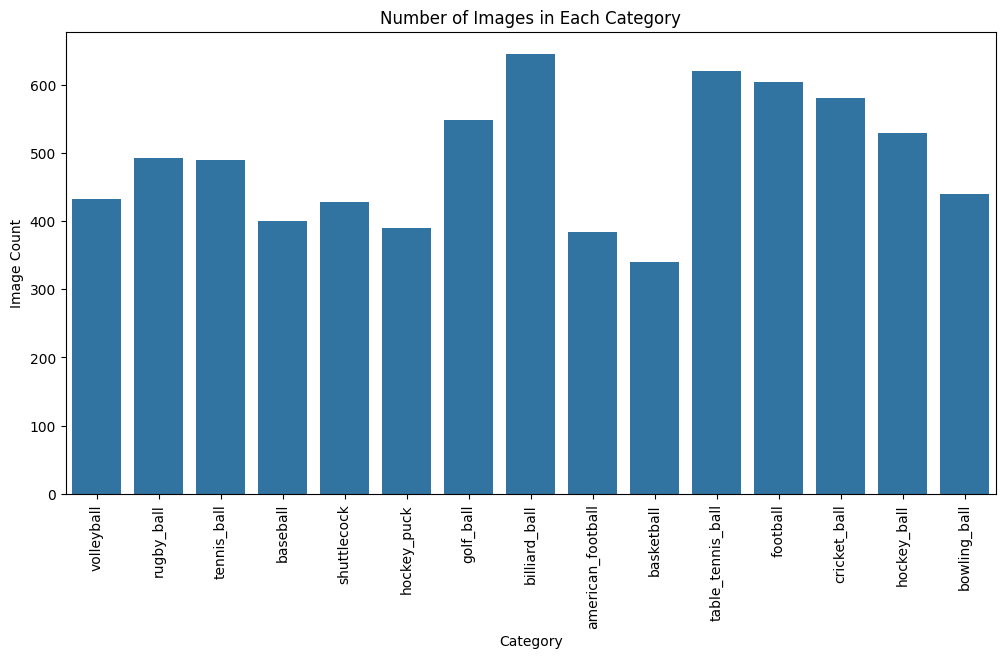

In [3]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Directory path (update with the correct path to your 'train' directory)
train_dir = "/content/sports_balls_dataset/train"

# Dictionary to store subdirectory names and file counts
data = {
    "Category": [],
    "Image Count": []
}

# Loop through each subdirectory
for sub_dir in os.listdir(train_dir):
    sub_dir_path = os.path.join(train_dir, sub_dir)
    if os.path.isdir(sub_dir_path):
        # Count the number of files (images) in the subdirectory
        num_files = len([
            f for f in os.listdir(sub_dir_path)
            if os.path.isfile(os.path.join(sub_dir_path, f))
        ])
        data["Category"].append(sub_dir)
        data["Image Count"].append(num_files)

# Convert the data to a pandas DataFrame
df = pd.DataFrame(data)

# Create the bar plot using Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x="Category", y="Image Count", data=df)
plt.xticks(rotation=90)
plt.title("Number of Images in Each Category")
plt.ylabel("Image Count")
plt.xlabel("Category")
plt.show()

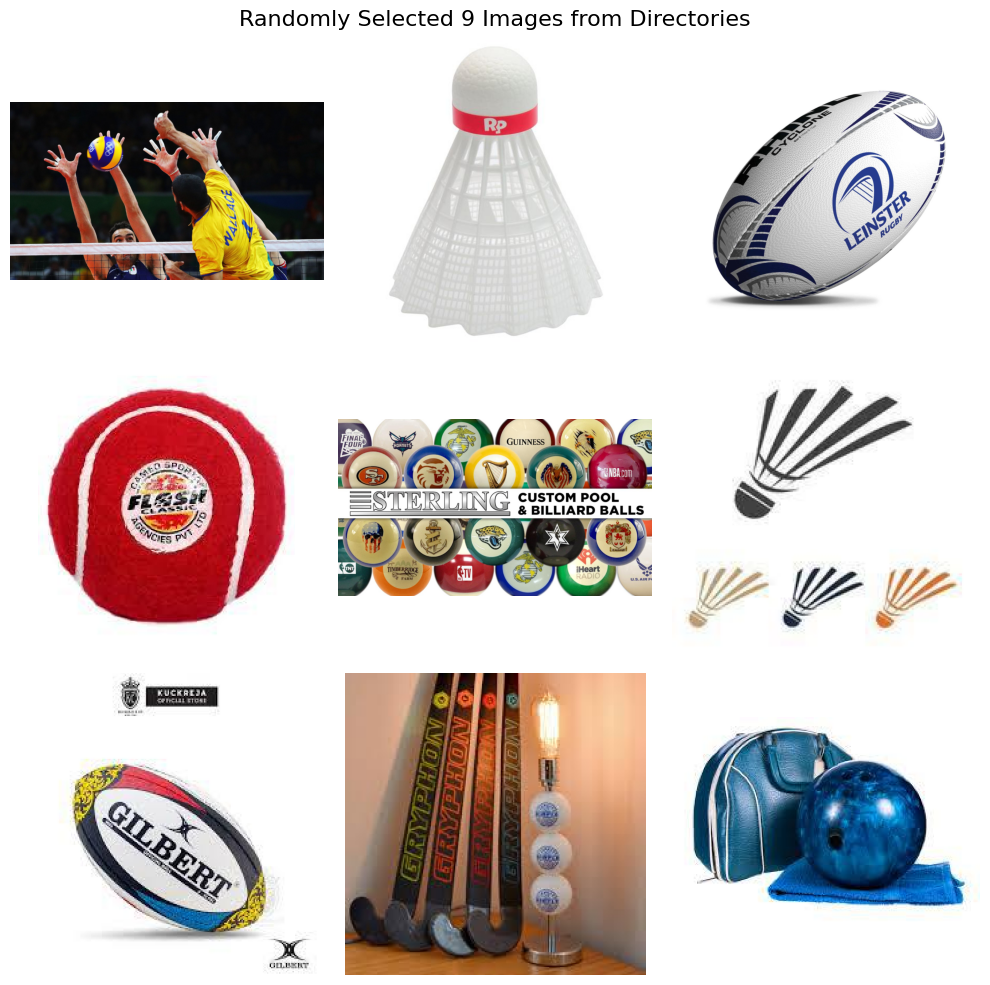

In [4]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Directory path (update with the correct path to your 'train' directory)
train_dir = "/content/sports_balls_dataset/train"

# Get all image file paths from all subdirectories
all_images = []
for sub_dir in os.listdir(train_dir):
    sub_dir_path = os.path.join(train_dir, sub_dir)
    if os.path.isdir(sub_dir_path):
        all_images.extend([
            os.path.join(sub_dir_path, f)
            for f in os.listdir(sub_dir_path)
            if os.path.isfile(os.path.join(sub_dir_path, f))
        ])

# Randomly select 9 images
random_images = random.sample(all_images, 9)

# Plot the images in a 3x3 grid
plt.figure(figsize=(10, 10))
for i, image_path in enumerate(random_images):
    img = mpimg.imread(image_path)
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis("off")

plt.suptitle("Randomly Selected 9 Images from Directories", fontsize=16)
plt.tight_layout()
plt.show()

In [5]:
# Set up directory and parameters
train_dir = "/content/sports_balls_dataset/train"
img_size = (224, 224)  # ResNet50 standard input size
batch_size = 32        # Adjust batch size as per your GPU capacity

In [6]:
# Data Augmentation layers (applied during training)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),   # Random horizontal flip
    layers.RandomRotation(0.1),         # Random rotation
    layers.RandomZoom(0.1),             # Random zoom
])

In [7]:
# Load training and validation datasets using image_dataset_from_directory
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="categorical",
    validation_split=0.2,   # 80/20 split for training/validation
    subset="training",
    seed=123,               # For reproducibility
    image_size=img_size,
    batch_size=batch_size
)

Found 7328 files belonging to 15 classes.
Using 5863 files for training.


In [8]:
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="categorical",
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

Found 7328 files belonging to 15 classes.
Using 1465 files for validation.


In [9]:
# Apply data augmentation only to the training data
train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)

In [10]:
# Optional: Prefetch data for performance improvement
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x

    # First 1x1 convolution to reduce dimensions
    x = layers.Conv2D(filters, kernel_size=1, strides=stride, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # Second 3x3 convolution
    x = layers.Conv2D(filters, kernel_size=kernel_size, strides=1, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # Third 1x1 convolution to restore dimensions
    x = layers.Conv2D(filters * 4, kernel_size=1, strides=1, padding="same")(x)
    x = layers.BatchNormalization()(x)

    # Adjust shortcut connection if necessary
    if stride != 1 or shortcut.shape[-1] != filters * 4:
        shortcut = layers.Conv2D(
            filters * 4, kernel_size=1, strides=stride, padding="same"
        )(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    # Add shortcut
    x = layers.Add()([x, shortcut])
    x = layers.Activation("relu")(x)

    return x

In [ ]:
def build_resnet50(input_shape=(224, 224, 3), num_classes=15):
    inputs = tf.keras.Input(shape=input_shape)

    # Initial Convolution and MaxPooling
    x = layers.Conv2D(64, kernel_size=7, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding="same")(x)

    # Residual Blocks (Bottleneck Architecture)
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=64)

    x = residual_block(x, filters=128, stride=2)
    x = residual_block(x, filters=128)
    x = residual_block(x, filters=128)
    x = residual_block(x, filters=128)

    x = residual_block(x, filters=256, stride=2)
    x = residual_block(x, filters=256)
    x = residual_block(x, filters=256)
    x = residual_block(x, filters=256)
    x = residual_block(x, filters=256)
    x = residual_block(x, filters=256)

    x = residual_block(x, filters=512, stride=2)
    x = residual_block(x, filters=512)
    x = residual_block(x, filters=512)

    # Global Average Pooling and Output
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs, outputs)
    return model

In [ ]:
# Build the model
model = build_resnet50(input_shape=(224, 224, 3))
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │      9,472 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 56,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 56, 56,    │      4,160 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │     36,928 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 56, 56,    │     16,640 │ activation_2[0][… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │     16,640 │ max_pooling2d[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │      1,024 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 56, 56,    │          0 │ add[0][0]       

 Total params: 23,618,447 (90.10 MB)

 Trainable params: 23,565,327 (89.89 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=5  # Adjust epochs as needed
)

Epoch 1/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 184s 682ms/step - accuracy: 0.1384 - loss: 3.3661 - val_accuracy: 0.0778 - val_loss: 13.1517
Epoch 2/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 94s 506ms/step - accuracy: 0.2102 - loss: 2.4992 - val_accuracy: 0.2184 - val_loss: 2.6790
Epoch 3/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 94s 512ms/step - accuracy: 0.2761 - loss: 2.2898 - val_accuracy: 0.1959 - val_loss: 3.1488
Epoch 4/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 95s 514ms/step - accuracy: 0.2458 - loss: 2.4466 - val_accuracy: 0.1652 - val_loss: 3.3300
Epoch 5/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 142s 513ms/step - accuracy: 0.3260 - loss: 2.1796 - val_accuracy: 0.2457 - val_loss: 2.6811


## Pretrained model and fine tuning

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

# Set up directory and parameters
train_dir = "/content/sports_balls_dataset/train"
img_size = (224, 224)
batch_size = 32
num_classes = 15  # Update this with the actual number of classes in your dataset

# Load the pre-trained ResNet50 model excluding the top layers
base_model = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

In [ ]:
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
# Freeze the base model layers
base_model.trainable = False

# Create a new model on top of the pre-trained base model
inputs = tf.keras.Input(shape=(224, 224, 3))

# Normalization layer
x = layers.Rescaling(1.0 / 255)(inputs)

# Pass the inputs through the pre-trained ResNet50 base model
x = base_model(x, training=False)

# Global average pooling to reduce the output to a single vector per image
x = layers.GlobalAveragePooling2D()(x)

# Add a fully connected layer with the number of classes
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)  # Dropout to reduce overfitting

# Final output layer with softmax activation for classification
outputs = layers.Dense(num_classes, activation="softmax")(x)

# Build the model
model = models.Model(inputs, outputs)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,116,111 (92.00 MB)

 Trainable params: 528,399 (2.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
# Load training and validation datasets using image_dataset_from_directory
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

# Prefetch data for performance improvement
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

Found 7328 files belonging to 15 classes.
Using 5863 files for training.
Found 7328 files belonging to 15 classes.
Using 1465 files for validation.


In [ ]:
# Train the new layers while keeping the base model frozen
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=5  # Adjust epochs as needed
)

Epoch 1/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 42s 166ms/step - accuracy: 0.0949 - loss: 2.7831 - val_accuracy: 0.1249 - val_loss: 2.6207
Epoch 2/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 20s 107ms/step - accuracy: 0.1180 - loss: 2.6348 - val_accuracy: 0.1345 - val_loss: 2.5855
Epoch 3/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 19s 104ms/step - accuracy: 0.1261 - loss: 2.6056 - val_accuracy: 0.1686 - val_loss: 2.5652
Epoch 4/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.1427 - loss: 2.5909 - val_accuracy: 0.1570 - val_loss: 2.5650
Epoch 5/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 19s 104ms/step - accuracy: 0.1454 - loss: 2.5625 - val_accuracy: 0.1884 - val_loss: 2.5382


In [ ]:
# Load the pre-trained ResNet50 model excluding the top layers
base_model = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)  # Pretrained on ImageNet

# Unfreeze the last few layers of the base model for fine-tuning
base_model.trainable = True

# Set how many layers to fine-tune
# Example: fine-tune the last layers starting from this index
fine_tune_at = 140  # Unfreeze from this layer onwards

# Freeze all layers before fine_tune_at
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [ ]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,172,911 (96.03 MB)

 Trainable params: 528,399 (2.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 1,056,800 (4.03 MB)

In [ ]:
# Compile the model again after unfreezing layers (lower LR for fine-tuning)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Lower LR for fine-tuning
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
# Fine-tune the model
fine_tune_history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=5  # Increase epochs for fine-tuning if needed
)

Epoch 1/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 40s 159ms/step - accuracy: 0.1659 - loss: 2.5402 - val_accuracy: 0.1877 - val_loss: 2.5301
Epoch 2/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 20s 106ms/step - accuracy: 0.1564 - loss: 2.5340 - val_accuracy: 0.1932 - val_loss: 2.5240
Epoch 3/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 20s 107ms/step - accuracy: 0.1695 - loss: 2.5243 - val_accuracy: 0.1863 - val_loss: 2.5179
Epoch 4/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 20s 103ms/step - accuracy: 0.1668 - loss: 2.5129 - val_accuracy: 0.1911 - val_loss: 2.5154
Epoch 5/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 20s 107ms/step - accuracy: 0.1651 - loss: 2.5242 - val_accuracy: 0.1925 - val_loss: 2.5141


## Inception Model From Scratch

In [37]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [48]:
# Inception module as defined in the paper
def inception_module(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_proj):

    # 1x1 convolution
    conv_1x1 = layers.Conv2D(
        filters_1x1, (1, 1),
        padding='same',
        activation='relu'
    )(x)

    # 3x3 convolution
    conv_3x3 = layers.Conv2D(
        filters_3x3_reduce, (1, 1),
        padding='same',
        activation='relu'
    )(x)
    conv_3x3 = layers.Conv2D(
        filters_3x3, (3, 3),
        padding='same',
        activation='relu'
    )(conv_3x3)

    # 5x5 convolution
    conv_5x5 = layers.Conv2D(
        filters_5x5_reduce, (1, 1),
        padding='same',
        activation='relu'
    )(x)
    conv_5x5 = layers.Conv2D(
        filters_5x5, (5, 5),
        padding='same',
        activation='relu'
    )(conv_5x5)

    # Max pooling followed by 1x1 convolution
    pool_proj = layers.MaxPooling2D(
        (3, 3),
        strides=(1, 1),
        padding='same'
    )(x)
    pool_proj = layers.Conv2D(
        filters_pool_proj, (1, 1),
        padding='same',
        activation='relu'
    )(pool_proj)

    # Concatenate filters from all branches
    output = layers.concatenate(
        [conv_1x1, conv_3x3, conv_5x5, pool_proj],
        axis=-1
    )

    return output

In [49]:
# Auxiliary classifier for training (deep supervision)
def auxiliary_classifier(x, num_classes):
    aux = layers.AveragePooling2D((5, 5), strides=(3, 3))(x)
    aux = layers.Conv2D(128, (1, 1), padding='same', activation='relu')(aux)
    aux = layers.Flatten()(aux)
    aux = layers.Dense(1024, activation='relu')(aux)
    aux = layers.Dropout(0.7)(aux)
    aux = layers.Dense(num_classes, activation='softmax')(aux)
    return aux


In [50]:
# Build the GoogLeNet model with two auxiliary classifiers
def build_googlenet(input_shape, num_classes):
    input_layer = layers.Input(shape=input_shape)

    # Normalization
    x = layers.Rescaling(1.0 / 255)(input_layer)

    # Initial convolution and max pooling
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Second convolution and max pooling
    x = layers.Conv2D(192, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Inception modules
    x = inception_module(x, 64, 96, 128, 16, 32, 32)     # 3a
    x = inception_module(x, 128, 128, 192, 32, 96, 64)  # 3b

    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = inception_module(x, 192, 96, 208, 16, 48, 64)   # 4a
    aux1 = auxiliary_classifier(x, num_classes)

    x = inception_module(x, 160, 112, 224, 24, 64, 64)  # 4b
    x = inception_module(x, 128, 128, 256, 24, 64, 64)  # 4c
    x = inception_module(x, 112, 144, 288, 32, 64, 64)  # 4d
    aux2 = auxiliary_classifier(x, num_classes)

    x = inception_module(x, 256, 160, 320, 32, 128, 128)  # 4e
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = inception_module(x, 256, 160, 320, 32, 128, 128)  # 5a
    x = inception_module(x, 384, 192, 384, 48, 128, 128)  # 5b

    # Final classifier
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    output = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(
        inputs=input_layer,
        outputs=[output, aux1, aux2]
    )

    return model

In [57]:
def duplicate_labels(x, y):
    return x, (y, y, y)

In [58]:
train_dataset = train_dataset.map(duplicate_labels)
validation_dataset = validation_dataset.map(duplicate_labels)

In [59]:
# Model parameters
input_shape = (224, 224, 3)   # ImageNet image size
num_classes = 15              # Number of classes for classification

# Build the model
googlenet = build_googlenet(input_shape, num_classes)

# Model summary
googlenet.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_4         │ (None, 224, 224,  │          0 │ input_layer_6[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_290 (Conv2D) │ (None, 112, 112,  │      9,472 │ rescaling_4[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_65    │ (None, 56, 56,    │          0 │ conv2d_290[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_291 (Conv2D) │ (None, 56, 56,    │    110,784 │ max_pooling2d_65… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_66    │ (None, 28, 28,    │          0 │ conv2d_291[0][0]  │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_293 (Conv2D) │ (None, 28, 28,    │     18,528 │ max_pooling2d_66… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_295 (Conv2D) │ (None, 28, 28,    │      3,088 │ max_pooling2d_66… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_67    │ (None, 28, 28,    │          0 │ max_pooling2d_66… │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_292 (Conv2D) │ (None, 28, 28,    │     12,352 │ max_pooling2d_66… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_294 (Conv2D) │ (None, 28, 28,    │    110,720 │ conv2d_293[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_296 (Conv2D) │ (None, 28, 28,    │     12,832 │ conv2d_295[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_297 (Conv2D) │ (None, 28, 28,    │      6,176 │ max_pooling2d_67… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_45      │ (None, 28, 28,    │          0 │ conv2d_292[0][0], │
│ (Concatenate)       │ 256)              │            │ conv2d_294[0][0], │
│                     │                   │            │ conv2d_296[0][0], │
│                     │                   │            │ conv2d_297[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_299 (Conv2D) │ (None, 28, 28,    │     32,896 │ concatenate_45[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_301 (Conv2D) │ (None, 28, 28,    │      8,224 │ concatenate_45[0… │
│                     │ 32)               │            │                 

 Total params: 10,345,245 (39.46 MB)

 Trainable params: 10,345,245 (39.46 MB)

 Non-trainable params: 0 (0.00 B)

In [52]:
# Load training and validation datasets using image_dataset_from_directory
train_dir = "/content/sports_balls_dataset/train"
# Set up directory and parameters
img_size = (224, 224)
batch_size = 32
num_classes = 15


train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

# Prefetch data for performance improvement
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

Found 7328 files belonging to 15 classes.
Using 5863 files for training.
Found 7328 files belonging to 15 classes.
Using 1465 files for validation.


In [53]:
googlenet.output_names

ListWrapper(['dense_24', 'dense_21', 'dense_23'])

In [64]:
googlenet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss={
        "dense_29": "sparse_categorical_crossentropy",
        "dense_26": "sparse_categorical_crossentropy",
        "dense_28": "sparse_categorical_crossentropy",
    },
    loss_weights={
        "dense_29": 1.0,
        "dense_26": 0.3,
        "dense_28": 0.3,
    },
    metrics={
        "dense_29": "accuracy",
        "dense_26": "accuracy",
        "dense_28": "accuracy",
    }
)

In [65]:
history = googlenet.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=2
)

Epoch 1/2
184/184 ━━━━━━━━━━━━━━━━━━━━ 110s 348ms/step - dense_26_accuracy: 0.0794 - dense_26_loss: 2.7005 - dense_28_accuracy: 0.0725 - dense_28_loss: 2.7034 - dense_29_accuracy: 0.0773 - dense_29_loss: 2.7014 - loss: 4.3225 - val_dense_26_accuracy: 0.1495 - val_dense_26_loss: 2.5849 - val_dense_28_accuracy: 0.1263 - val_dense_28_loss: 2.6063 - val_dense_29_accuracy: 0.1413 - val_dense_29_loss: 2.6151 - val_loss: 4.1724
Epoch 2/2
184/184 ━━━━━━━━━━━━━━━━━━━━ 29s 157ms/step - dense_26_accuracy: 0.1392 - dense_26_loss: 2.5868 - dense_28_accuracy: 0.1236 - dense_28_loss: 2.6126 - dense_29_accuracy: 0.1208 - dense_29_loss: 2.6072 - loss: 4.1670 - val_dense_26_accuracy: 0.1966 - val_dense_26_loss: 2.4715 - val_dense_28_accuracy: 0.1768 - val_dense_28_loss: 2.4921 - val_dense_29_accuracy: 0.1836 - val_dense_29_loss: 2.5039 - val_loss: 3.9937
